In [177]:
from __future__ import division

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc

In [112]:
Healthy = pd.read_csv('./Data/Healthy1.csv',header=None)
Amp = pd.read_csv('./Data/Amp1.csv',header=None)

In [113]:
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [114]:
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,0.132230,0.074660,-0.11889,0.012579,0.049360,0.051680,...,2.2354,4.9977,0.72193,0.78766,0.053909,0.085895,0.071485,0.090722,0.046334,0.127110
1,1,1,1,3,-0.077828,0.070436,-0.21730,-0.028075,0.042425,0.076308,...,2.2354,4.9974,0.72193,0.80493,0.055249,0.092283,0.096109,0.103440,0.095055,0.080526
2,1,1,1,3,-0.006114,0.034498,-0.20617,-0.025551,0.034052,0.071821,...,2.2313,4.9824,1.37100,0.81752,0.055180,0.096682,0.093441,0.077564,0.101470,0.067335
3,1,1,1,4,-0.154480,0.024149,0.31641,-0.031890,0.042762,0.069643,...,2.2358,4.9990,0.72193,0.51662,0.039205,0.099017,0.071918,0.094359,0.072023,0.086206
4,1,1,1,4,-0.163620,0.023899,0.32266,-0.042376,0.007777,0.056139,...,2.2360,4.9997,0.72193,0.68568,0.048051,0.093172,0.083448,0.118910,0.063367,0.049815


In [115]:
print len(Healthy)
print len(Amp)

1114
495


In [116]:
print len(Healthy.SubjID.unique())
print len(Amp.SubjID.unique())
print Healthy.Subjtype.unique()
print Amp.Subjtype.unique()

10
7
[1]
[0]


In [117]:
#Healthy
print ('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9]))
print ('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9]))

Nfalls = 628
Nactivities = 486


In [118]:
#Amp
print ('Nfalls = %s')%(len(Amp[Amp.Falltype<9]))
print ('Nactivities = %s')%(len(Amp[Amp.Falltype==9]))

Nfalls = 188
Nactivities = 307


In [119]:
#transform to binary class
#Healthy.Falltype.apply(lambda x: x<9 ) 

In [120]:
#selecting cols by index
Healthy.iloc[1:5, 0:4]

,SubjID,Loc,Subjtype,Falltype
1,1,1,1,3
2,1,1,1,3
3,1,1,1,4
4,1,1,1,4


### Train on healthy and test on amputees

In [121]:
#transform to binary class
Xtr = Healthy.iloc[:,5:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,5:].as_matrix()
yte = Amp.Falltype.as_matrix()

In [122]:
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [123]:
print Xtr.shape
print np.unique(ytr)
print Xte.shape
print np.unique(yte)

(1114, 1210)
[0 1]
(495, 1210)
[0 1]


In [124]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [125]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[ 0.00024631  0.          0.00010011 ...,  0.00019244  0.00021533
  0.00013573]
[ 0.00134585  0.          0.00051167 ...,  0.00097597  0.00101868
  0.00095013]


In [127]:
importance_norm = importance/np.max(importance)

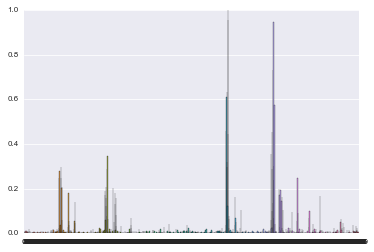

In [129]:
#using Seaborn
ax = sns.barplot(x=indices,y=importance_norm[indices])
sns.set_context("paper")
plt.figure(figsize=(8,6))

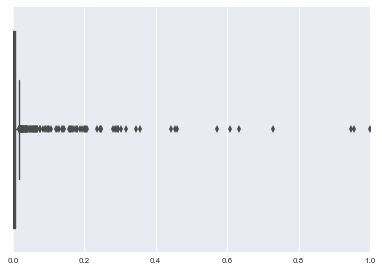

In [130]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [154]:
qc = np.percentile(importance_norm,[75])
#indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
len(indmax)

47

In [155]:
forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)
forest.fit(Xtr[:,indmax],ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [167]:
ypred = forest.predict(Xte[:,indmax])
yscore = forest.predict_proba(Xte[:,indmax])
yscore = yscore[:,1]

In [168]:
acc = np.sum(ypred==yte)/len(ypred)
print acc

0.965656565657


In [179]:
fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
roc_auc = auc(fpr, tpr)
print('AUC = %s'%roc_auc)

AUC = 0.996274863123


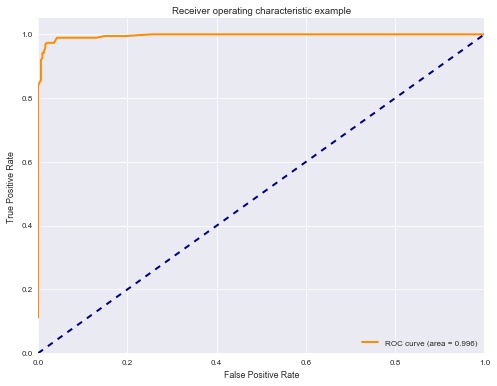

In [183]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy Amputee - Random forest')
plt.legend(loc="lower right")

In [57]:
glmnetCV = ElasticNetCV(l1_ratio=[.1,.5,.7,.9,.95,.99,1],cv=5,random_state=10,verbose=1,normalize=False)

In [ ]:
glmnetCV.fit(Xtr,ytr)